# Forecasting the Risk of Heart Disease

According to the World Health Organization (WHO), cardiovascular diseases (CVDs) are responsible for 17.9 million deaths annually. Numerous factors, including unhealthy diets, physical inactivity, and mental illnesses, can increase an individual's risk of developing CVD. Early identification of these risk factors is crucial for preventing many premature deaths.

In this project, we will utilize a [Kaggle dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) and develop a K-Nearest Neighbors classifier to accurately predict the likelihood of a patient developing heart disease in the future.



In [2]:
# Imports
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Exploratory Data Analysis

We begin by conducting some data exploration on our dataset. Each patient will have the following information collected about them:
1. __Age__: age of the patient [years]
2. __Sex__: sex of the patient [M: Male, F: Female]
3. __ChestPainType__: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. __RestingBP__: resting blood pressure [mm Hg]
5. __Cholesterol__: serum cholesterol [mm/dl]
6. __FastingBS__: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. __RestingECG__: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. __MaxHR__: maximum heart rate achieved [Numeric value between 60 and 202]
9. __ExerciseAngina__: exercise-induced angina [Y: Yes, N: No]
10. __Oldpeak__: oldpeak = ST [Numeric value measured in depression]
11. __ST_Slope__: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. __HeartDisease__: output class [1: heart disease, 0: Normal]

In [4]:
# Dataset source
df = pd.read_csv("heart-disease.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


The dataset includes both numerical and categotical data features. Need to inspect the datatype for each column.

In [6]:
print(df.dtypes)
df.dtypes.value_counts()

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


int64      6
object     5
float64    1
Name: count, dtype: int64

There are 7 numerical features and 5 categorical features.

# Numerical Data

In [9]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


From the calculated values, we can conclude the following:
- The average age of patients is approximately 53 years.
- The median cholesterol level is higher than the mean by roughly 25 mm/dl, suggesting a left-skewed distribution with potential outliers affecting the distribution.
- RestingBP and Cholesterol have minimum values of zero, which is implausible.
- There appear to be no missing values in these columns, though we need to verify this across the entire dataset.

RestingBP cannot be zero, and according to the American Heart Association, serum cholesterol is a composite of different measurements, making it unlikely for Cholesterol to be zero as well. We will need to clean these values later.
Next, we will examine the categorical variables. It will also be beneficial to analyze how the target feature, HeartDisease, relates to these categories. Before that, let's quickly check for any missing values in the dataset.

In [11]:
# Check for null values
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

No null values

# Categorical Data

In [14]:
df.describe(include = ['object'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


We can confirm that those columns are indeed categorical given the number of unique values in each of them. However, we can't gather much else from this information alone. FastingBS and HeartDisease are categorical as well since they only contain binary values.

In [16]:
df["FastingBS"].unique(), df["HeartDisease"].unique()

(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

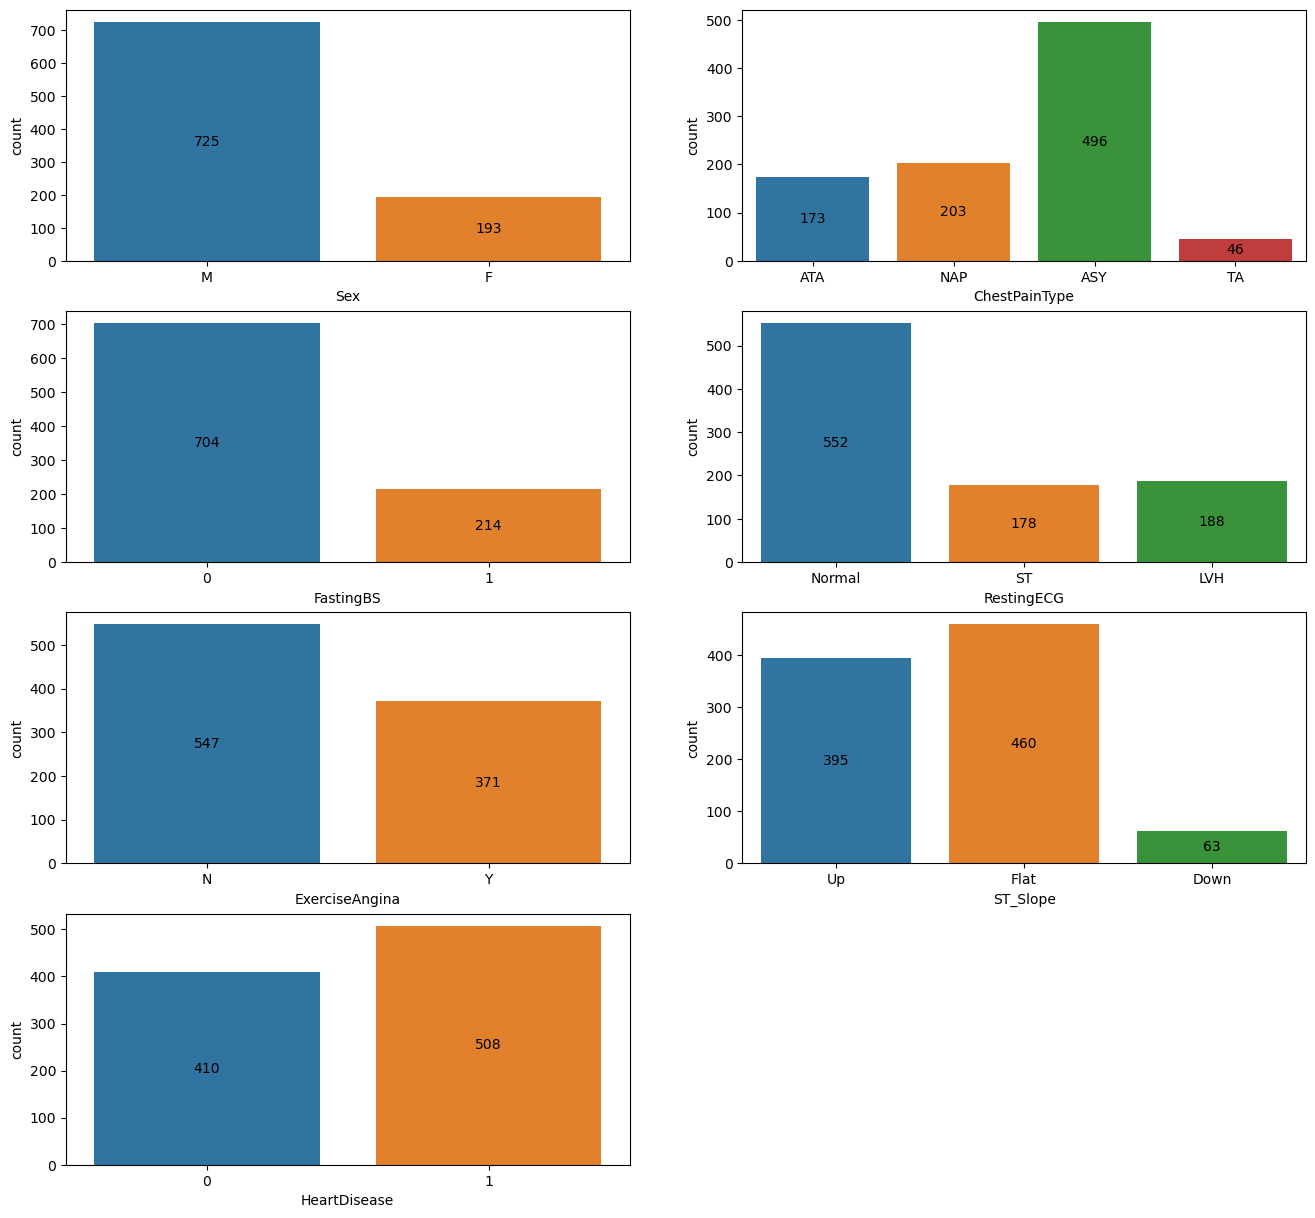

In [17]:
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

fig = plt.figure(figsize = (16, 15))

for index, col in enumerate(categorical_cols):
    axes = plt.subplot(4, 2, index + 1)
    sns.countplot(x = df[col], axes = axes)

    # Adding labels to each bar
    for container in axes.containers:
        axes.bar_label(container, label_type = "center")


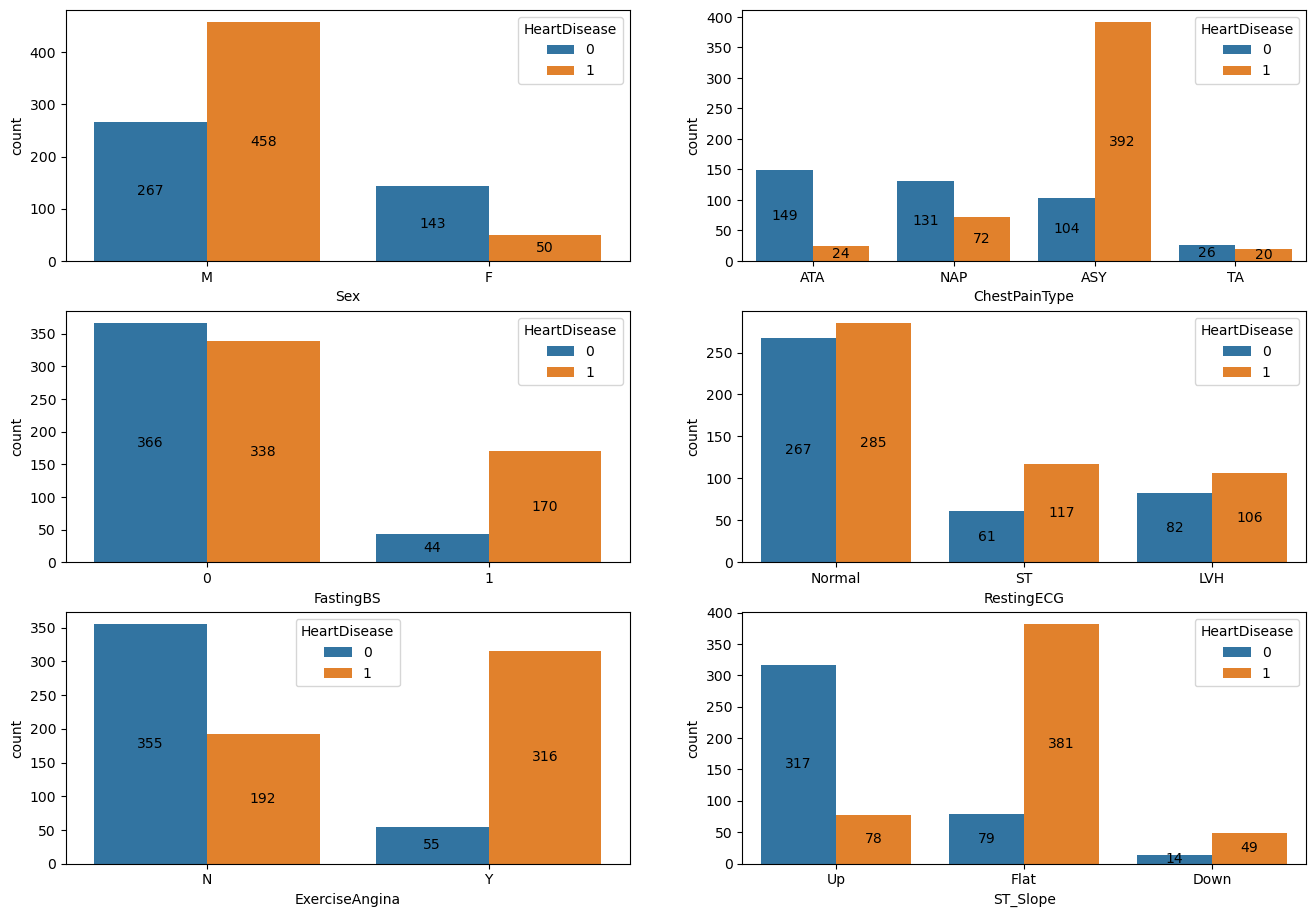

In [18]:
# Group by "HeartDisease"
fig = plt.figure(figsize = (16, 15))
df["HeartDisease"] = df["HeartDisease"].astype(str)

for index, col in enumerate(categorical_cols[:-1]):
    axes = plt.subplot(4, 2, index + 1)
    sns.countplot(x = df[col], hue = df["HeartDisease"], axes = axes)

    # Add labels to each bar
    for container in axes.containers:
        axes.bar_label(container, label_type = "center")

In [19]:
df[df["RestingBP"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [20]:
df[df["Cholesterol"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [21]:
df_clean = df.copy()

# Remove all zero values
df_clean = df_clean[df_clean["RestingBP"] != 0]

hd_mask = df_clean["HeartDisease"] == 0

cholesterol_no_hd = df_clean.loc[hd_mask, "Cholesterol"]
cholesterol_hd = df_clean.loc[~hd_mask, "Cholesterol"]

df_clean.loc[hd_mask, "Cholesterol"] = cholesterol_no_hd.replace(to_replace = 0, value = cholesterol_no_hd.median())
df_clean.loc[~hd_mask, "Cholesterol"] = cholesterol_hd.replace(to_replace = 0, value = cholesterol_hd.median())

In [22]:
df_clean[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,240.600872,132.540894
std,54.009298,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,223.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


In [23]:
df_clean = pd.get_dummies(df_clean, drop_first = True)
df_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,HeartDisease_1
0,40,140,289,0,172,0.0,True,True,False,False,True,False,False,False,True,False
1,49,160,180,0,156,1.0,False,False,True,False,True,False,False,True,False,True
2,37,130,283,0,98,0.0,True,True,False,False,False,True,False,False,True,False
3,48,138,214,0,108,1.5,False,False,False,False,True,False,True,True,False,True
4,54,150,195,0,122,0.0,True,False,True,False,True,False,False,False,True,False


<Axes: >

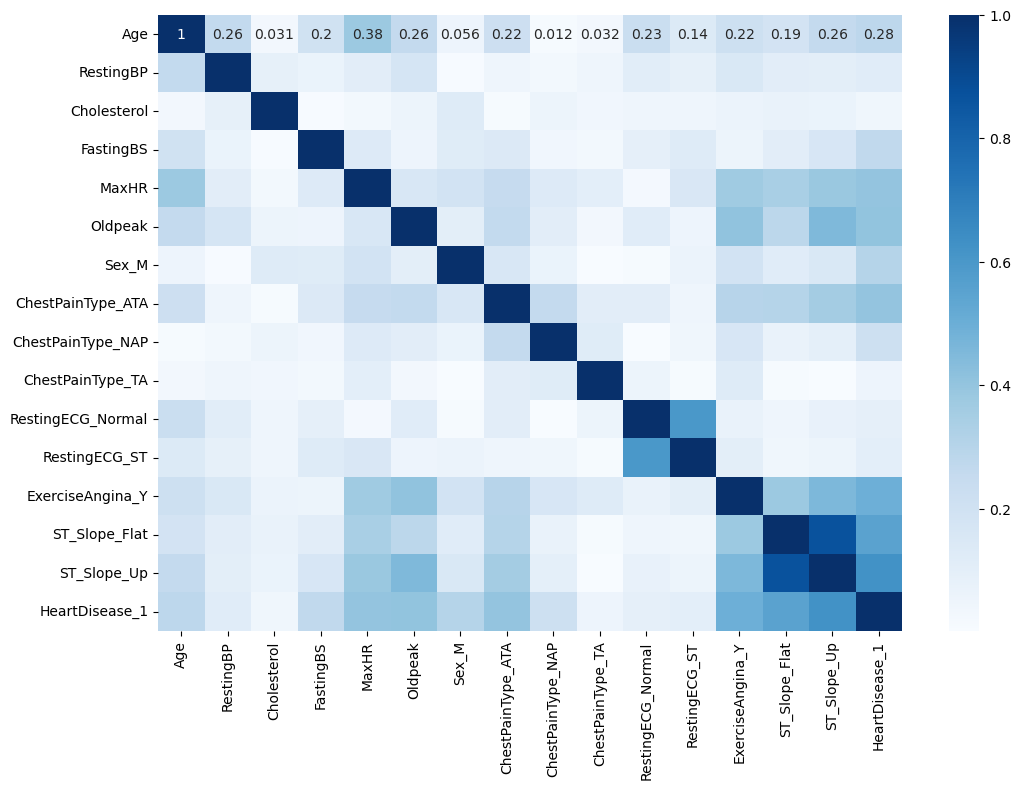

In [24]:
correlations = abs(df_clean.corr())
plt.figure(figsize = (12, 8))
sns.heatmap(correlations, annot = True, cmap = "Blues")

C:\Users\danny\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

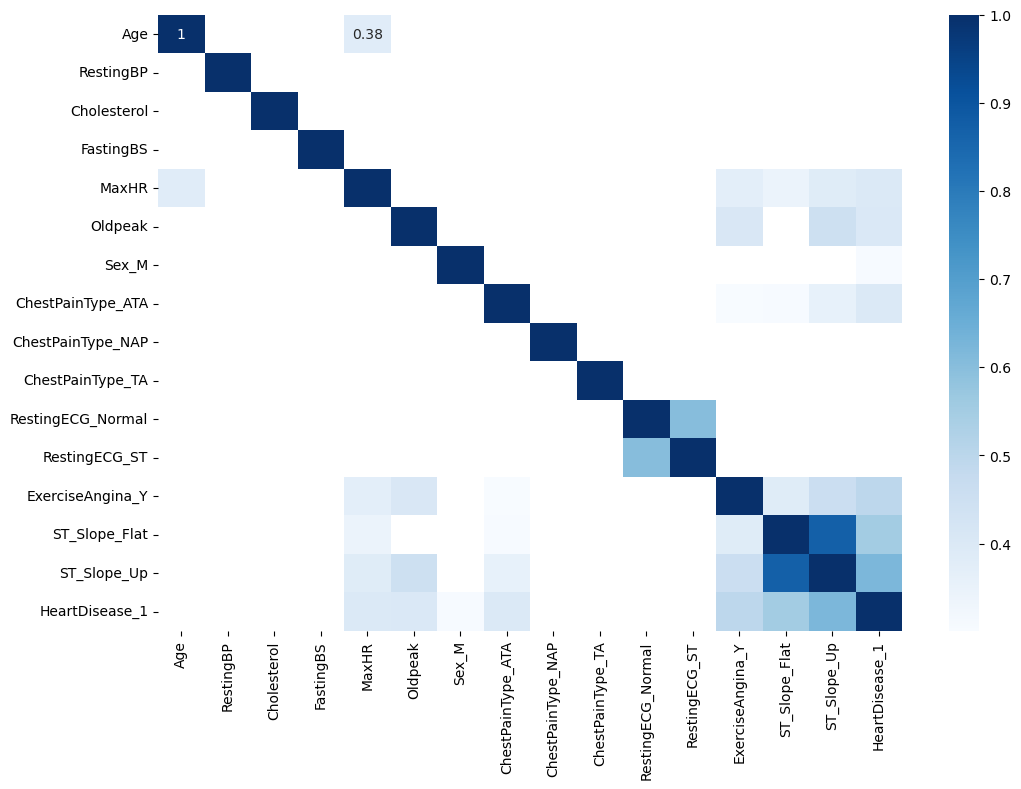

In [25]:
plt.figure(figsize = (12, 8))
sns.heatmap(correlations[correlations > 0.3], annot = True, cmap = "Blues")

In [26]:
x = df_clean.drop(["HeartDisease_1"], axis = 1)
y = df_clean["HeartDisease_1"]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.15, random_state = 417)

features = ["Oldpeak", "Sex_M", "ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up"]

# Using K Nearest Neighbours Method

In [28]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(x_train[[feature]], y_train)
    accuracy = knn.score(x_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 3, has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on Oldpeak and with k = 3, has an accuracy of 58.70%
The k-NN classifier trained on Sex_M and with k = 3, has an accuracy of 61.59%
The k-NN classifier trained on ExerciseAngina_Y and with k = 3, has an accuracy of 73.19%
The k-NN classifier trained on ST_Slope_Flat and with k = 3, has an accuracy of 81.88%
The k-NN classifier trained on ST_Slope_Up and with k = 3, has an accuracy of 55.07%


In [29]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train[features])
x_val_scaled = scaler.transform(x_val[features])

In [30]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train_scaled, y_train)
accuracy = knn.score(x_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 83.33


In [31]:
x = df_clean.drop(["HeartDisease_1"], axis = 1)
y = df_clean["HeartDisease_1"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 417)

features = ["Oldpeak", "Sex_M", "ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up"]

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train[features])

In [70]:
grid_params = {"n_neighbors": range(1, 20),
               "metric": ["minkowski", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring = "accuracy")
knn_grid.fit(x_train_scaled, y_train)
               

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [63]:
knn_grid.best_score_*100, knn_grid.best_params_

(83.43507030603806, {'metric': 'minkowski', 'n_neighbors': 19})

In [64]:
x_test_scaled = scaler.transform(x_test[features])
predictions = knn_grid.best_estimator_.predict(x_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 86.96


In [35]:
print("Distribution of patients by their sex in the entire dataset")
print(x.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(x_train.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(x_test.Sex_M.value_counts())

Distribution of patients by their sex in the entire dataset
Sex_M
True     724
False    193
Name: count, dtype: int64

Distribution of patients by their sex in the training dataset
Sex_M
True     615
False    164
Name: count, dtype: int64

Distribution of patients by their sex in the test dataset
Sex_M
True     109
False     29
Name: count, dtype: int64


# Exploratory Data Analysis (EDA)
The majority of patients with heart disease had asymptomatic chest pain (ASY).
A significant number of patients with high fasting blood sugar levels (>120 mg/dl) were diagnosed with heart disease.
Many patients with exercise-induced angina and flat ST slope were diagnosed with heart disease.
# Feature Selection:
Features such as Oldpeak, ExerciseAngina_Y, ST_Slope_Flat, and ST_Slope_Up showed strong correlations with the target variable (HeartDisease).
Cholesterol did not show a strong correlation with heart disease, despite initial assumptions.
# Potential Bias and Distribution:
The dataset's skew towards male patients could induce bias in the model. The training and test sets maintained a similar distribution of sex, which helps ensure consistency but does not fully mitigate the inherent bias in the dataset.
